In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log
from os import listdir

## data augment keras
from keras.preprocessing import image as KP
##

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd() # /home/swl/Mask_RCNN

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs") # /home/swl/Mask_RCNN/logs

# Path to COCO trained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5") # /home/swl/Mask_RCNN/mask_rcnn_coco.h5

# Directory of images to train on
TRAIN_IMAGE_DIR = os.path.join(ROOT_DIR, "train")
VAL_IMAGE_DIR = os.path.join(ROOT_DIR, "val")
MASK_DIR = "/data/mask"#os.path.join(ROOT_DIR, "mask")

Using TensorFlow backend.


## Configurations

In [2]:
class StomachCancerConfig(Config):
    # Give the configuration a recognizable name
    NAME = "stomachcancer"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes
    
    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 4000

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 200
    
    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet101"
    
    # Learning rate and momentum
    # The Mask RCNN paper uses lr=0.02, but on TensorFlow it causes
    # weights to explode. Likely due to differences in optimzer
    # implementation.
    LEARNING_RATE = 0.001
    LEARNING_MOMENTUM = 0.9
    DECAY = 1e-6
    
    # Weight decay regularization
    WEIGHT_DECAY = 0.0001
    
config = StomachCancerConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DECAY                          1e-06
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.75
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           stomachcancer
NUM_CLASSES                    2
PO

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class StomachCancerDataset(utils.Dataset):

    def load_stomachcancer(self, dataset_dir, subset, return_stomachcancer=False):

        """Load a subset of the COCO dataset.
        dataset_dir: The root directory of the COCO dataset.
        subset: What to load (train, val, minival, valminusminival)
        class_ids: If provided, only loads images that have the given classes.
        return_coco: If True, returns the COCO object.
        """

        # Add classes
        self.add_class("stomachcancer", 1, "cancernest")
        #self.add_class("stomachcancer", 2, "benign")

        # Add images
        directorypath=os.path.join(dataset_dir, subset)
        file_names = next(os.walk(directorypath))[2]
        for fn in file_names:
            self.add_image("stomachcancer", image_id=fn.split(".")[0],
                           path=os.path.join(directorypath, fn),
                           width=config.IMAGE_SHAPE[1], height=config.IMAGE_SHAPE[0])
        
        if return_stomachcancer:
            return stomachcancer

    
    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]

        if info['path'].find('negative')>0:
            mask = np.ones([info['height'], info['width'], 1], dtype=np.uint8)
            #mask[:,1:512,0]=1;#mask[:,:,0]=1;mask[:,:,0]=1;mask[:,:,0]=1;
            class_ids = np.array([0])
        else:
            filename_list = listdir(MASK_DIR)
            for filename in filename_list:
                if filename.split('.')[0] == info['id'].split('__2means')[0]:
                    mask = np.load(os.path.join(MASK_DIR, filename))
                    class_ids = np.array([1 for num_nests in range(mask.shape[2])])
        return mask, class_ids

In [5]:
# Training dataset
dataset_train = StomachCancerDataset()
dataset_train.load_stomachcancer(TRAIN_IMAGE_DIR, "positive")
dataset_train.load_stomachcancer(TRAIN_IMAGE_DIR, "negative")
dataset_train.prepare()

# Validation dataset
dataset_val = StomachCancerDataset()
dataset_val.load_stomachcancer(VAL_IMAGE_DIR, "positive")
# dataset_val.load_stomachcancer(VAL_IMAGE_DIR, "negative")
dataset_val.prepare()

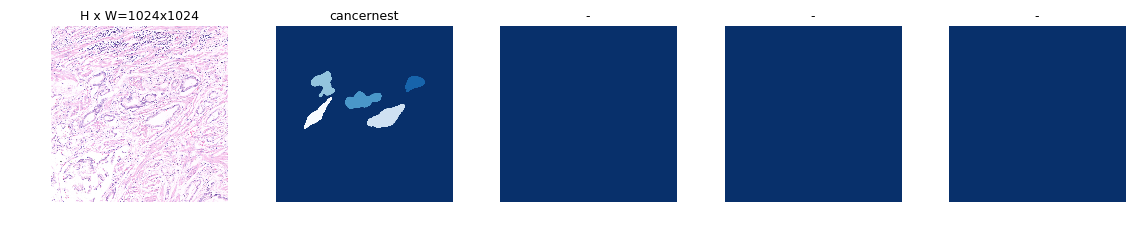

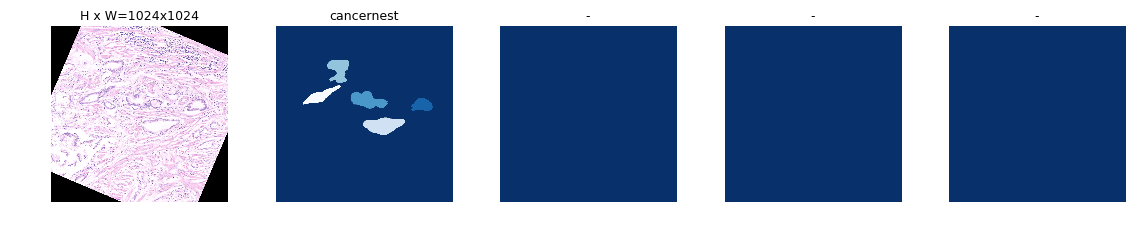

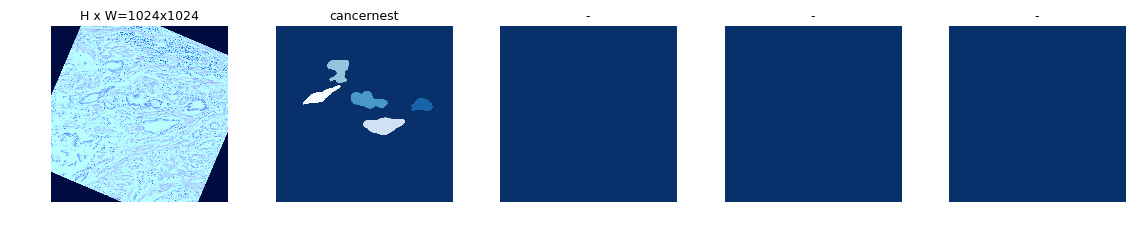

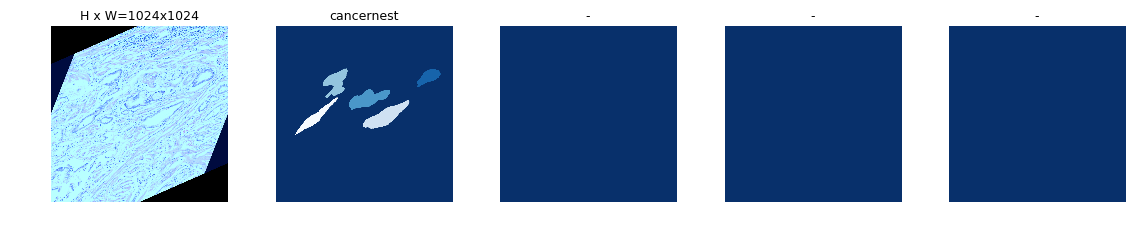

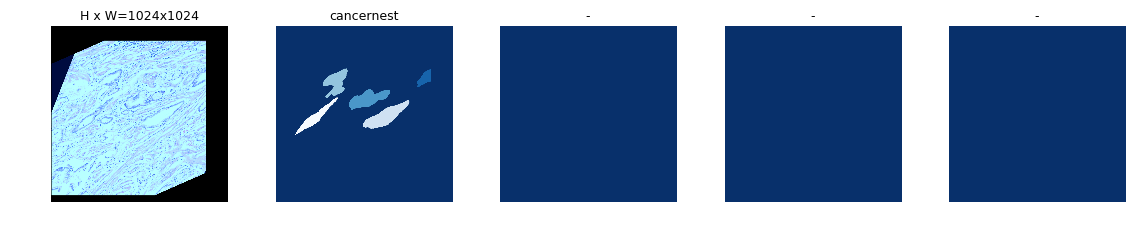

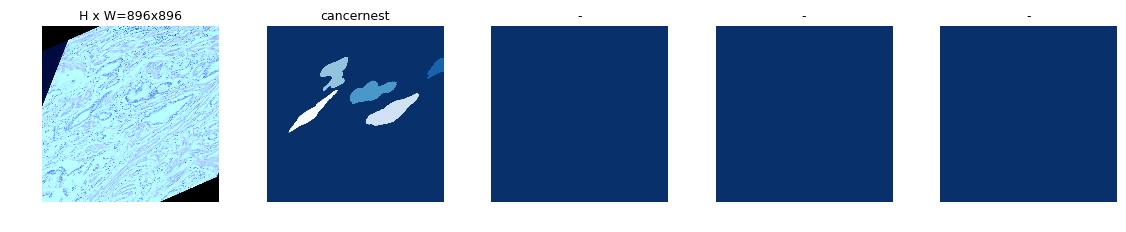

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 1)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    #### random totate
    rg = 45
    degree = np.random.uniform(-rg, rg)
    image = KP.random_rotation(image, degree,row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant')
    mask = KP.random_rotation(mask, degree,row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant')
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    ######
    #### random channel shift
    image = KP.random_channel_shift(image,100, channel_axis=2)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    ######
    #### random shear
    rg = 50
    intensity = np.random.uniform(-rg, rg)
    image = KP.random_shear(image,intensity, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0.0)
    mask = KP.random_shear(mask, intensity, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0.0)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    ######
    #### random crop
    size = 896
    while True:
        x = np.random.randint(0, 1024-size)
        y = np.random.randint(0, 1024-size)
        tmpimage = np.zeros([1024, 1024, 3], dtype=np.uint8)
        tmpimage[x:x+size,y:y+size,:] = image[x:x+size,y:y+size,:]
        tmpmask = np.zeros([1024, 1024, mask.shape[2]], dtype=np.uint8)
        tmpmask[x:x+size,y:y+size,:] = mask[x:x+size,y:y+size,:]
        visualize.display_top_masks(tmpimage, tmpmask, class_ids, dataset_train.class_names)
        tmpimage = image[x:x+size,y:y+size,:]
        tmpmask = mask[x:x+size,y:y+size,:]
        visualize.display_top_masks(tmpimage, tmpmask, class_ids, dataset_train.class_names)
        if 1 in tmpmask:
            image = tmpimage
            mask = tmpmask
            break
    ######

## Ceate Model

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])#
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)
#     model_path1 = os.path.join(MODEL_DIR, "stomachcancer20180327T2119/mask_rcnn_stomachcancer_0030.h5")
#     model.load_weights(model_path1, by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs= 3, 
            layers='heads')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs= 10, 
            layers="all")

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [6]:
class InferenceConfig(StomachCancerConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(MODEL_DIR, "stomachcancer20180412T1259/mask_rcnn_stomachcancer_0040.h5")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/swl/Mask_RCNN/logs/stomachcancer20180417T1020/mask_rcnn_stomachcancer_0010.h5


In [ ]:
# Test on a random image
# image_id = random.choice(dataset_val.image_ids)
# original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#     modellib.load_image_gt(dataset_val, inference_config, 
#                            image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_bbox)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))

In [ ]:
# results = model.detect([original_image], verbose=1)

# r = results[0]
# visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.

image_ids = np.random.choice(dataset_val.image_ids, 50)
print(len(dataset_val.image_ids))
APs = []
ap3=[]
ap5=[]
ap8=[]
ap10=[]
for image_id in image_ids:
# print(len(dataset_val.image_ids))
# for image_id in dataset_val.image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
#     visualize.plot_precision_recall(AP, precisions, recalls)
#     visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
#                         overlaps, dataset_val.class_names)
    ####################
    if AP<=0.3:
        ap3.append(AP)
    if AP>0.3 and AP<=0.5:
        ap5.append(AP)
    if AP>0.5 and AP<=0.8:
        ap8.append(AP)
    if AP>0.8:
        ap10.append(AP)
#     if AP == 0:
#         original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#             modellib.load_image_gt(dataset_val, inference_config, 
#                                    image_id, use_mini_mask=False)

#         visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))
#         results = model.detect([original_image], verbose=1)

#         r = results[0]
#         visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                                     dataset_val.class_names, r['scores'], ax=get_ax())
#         visualize.plot_precision_recall(AP, precisions, recalls)
#         visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
#                             overlaps, dataset_val.class_names)
#         print("AP: ", AP)
#         print("precisions: ", precisions)
#         print("recalls: ", recalls)
#         print("overlaps: ", overlaps)
#         break
    ###################
    APs.append(AP)

#print(np.mean(ap3),np.mean(ap5),np.mean(ap8),np.mean(ap10))
print(len(ap3),len(ap5),len(ap8),len(ap10))
print("mAP: ", np.mean(APs))

original_image           shape: (1024, 1024, 3)       min:   41.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max: 1024.00000
gt_class_id              shape: (7, 4)                min:    0.00000  max: 1024.00000
gt_bbox                  shape: (7, 4)                min:    0.00000  max: 1024.00000
gt_mask                  shape: (1024, 1024, 7)       min:    0.00000  max:    1.00000
Processing 1 images
image                    shape: (1024, 1024, 3)       min:   41.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min:  -77.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000
original_image           shape: (1024, 1024, 3)       min:   39.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max: 1024.00000
gt_class_id              shape: (7, 4)                min:  322.00000  max: 1023.00000
gt_bbox                

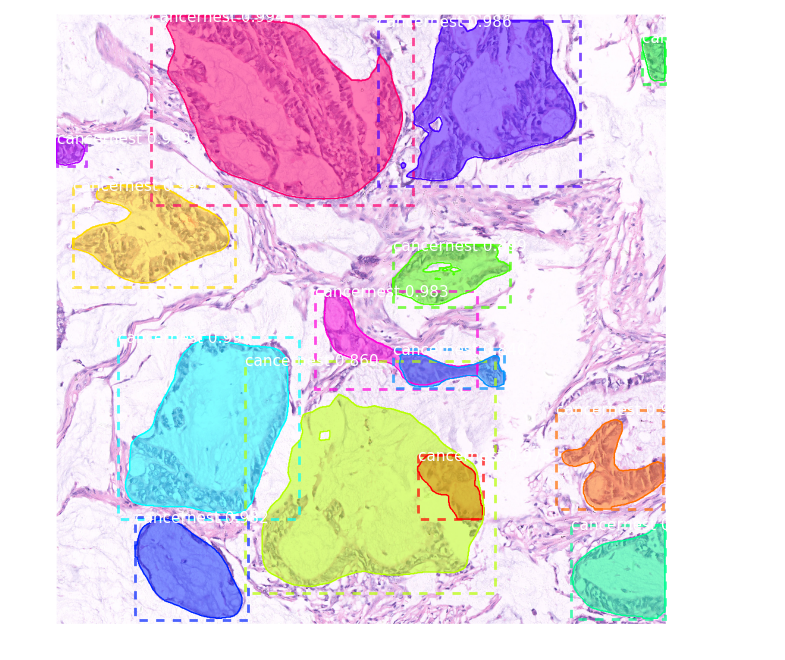

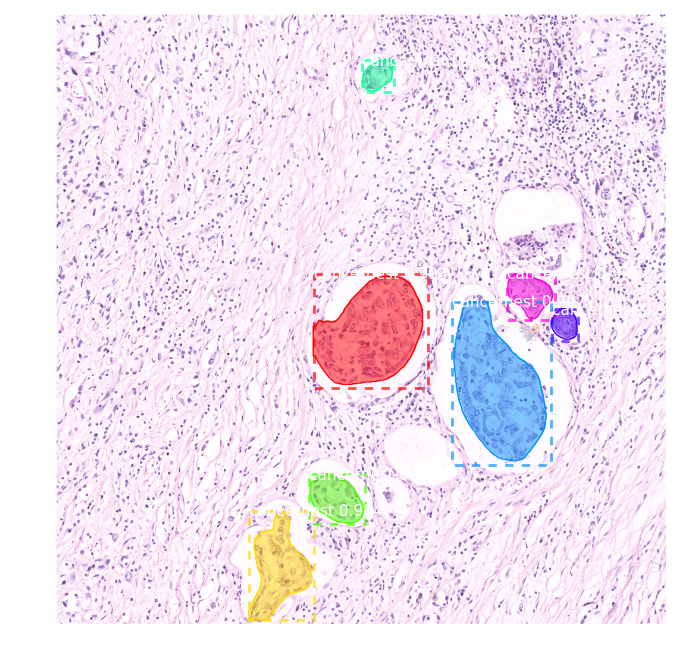

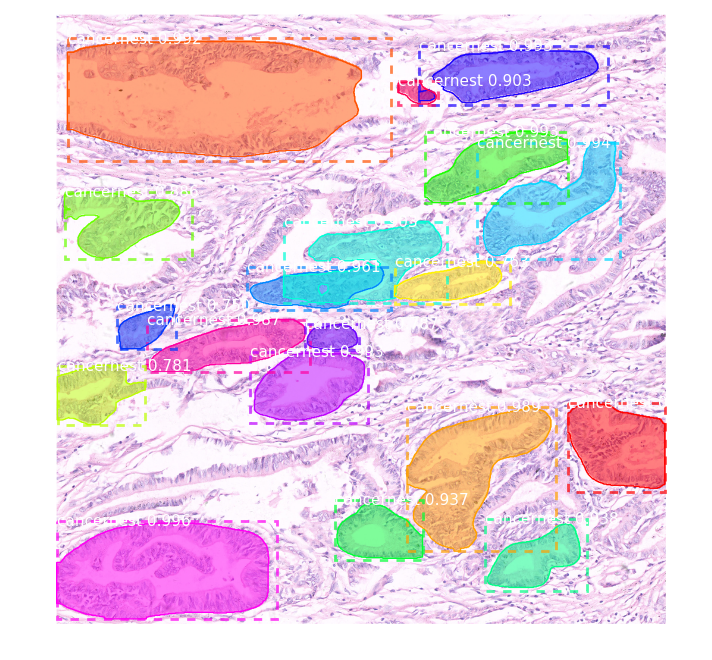

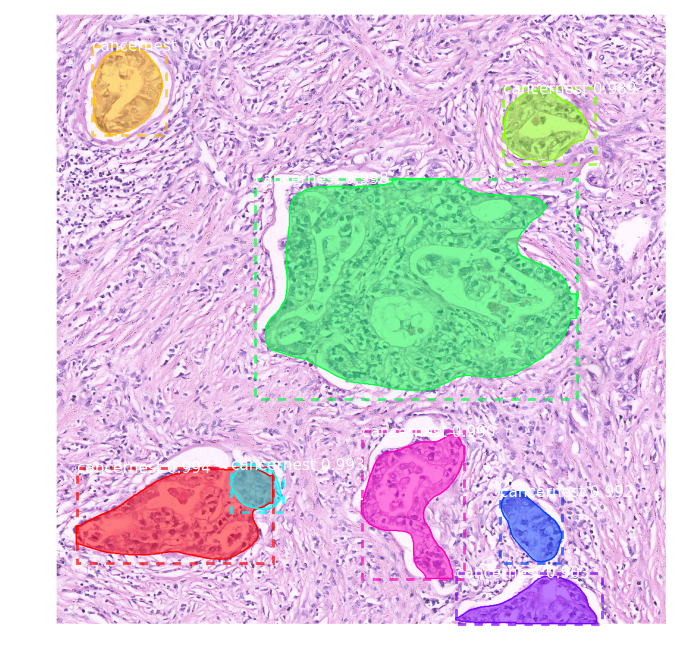

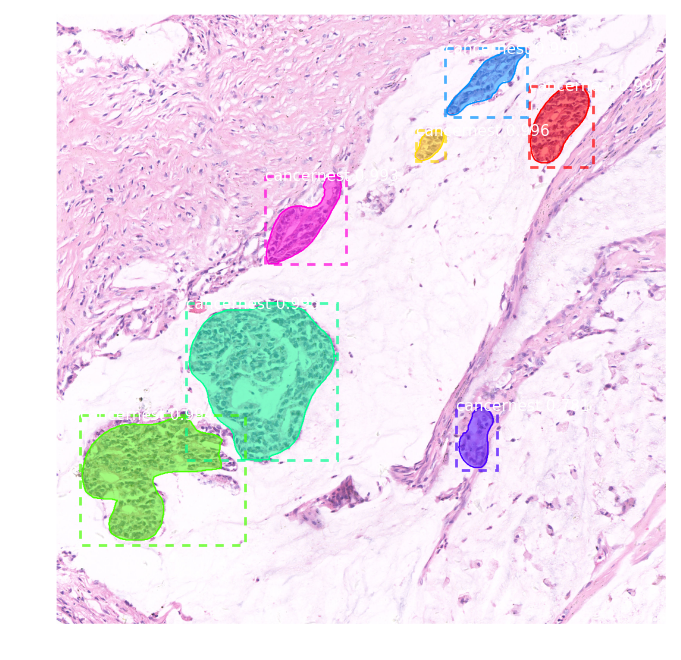

In [7]:
# image_ids = np.random.choice(dataset_val.image_ids,3)
for image_id in dataset_val.image_ids:
# for image_id in image_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)

    log("original_image", original_image)
    log("image_meta", image_meta)
    log("gt_class_id", gt_bbox)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

#     visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                                 dataset_train.class_names, figsize=(8, 8))

    results = model.detect([original_image], verbose=1)

    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], ax=get_ax())